# Fall Detection using SisFall Dataset
Daniela Dias, nMec 98039

In [2]:
# General-purpose libraries
import numpy as np
import pandas as pd

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import callbacks, layers, models

# Scikit-learn: model selection, metrics, utilities
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
)
from sklearn.utils import compute_class_weight

# Hyperparameter optimization
import optuna

# from plot_utils import optuna_visualizations, confusion_matrix_plot, roc_curve_plot, precision_recall_plot

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

## Utility Functions

In [4]:
# Plotting and visualization
import matplotlib.pyplot as plt
import optuna.visualization as vis

# Scikit-learn metrics and visualizations
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    roc_auc_score,
    roc_curve
)


def optuna_visualizations(study, params):
    # Visualize the hyperparameter combinations and their performance
    fig = vis.plot_contour(study, params=params)
    fig.show()

    # Visualize the optimization history
    fig = vis.plot_optimization_history(study)
    fig.show()

    # Visualize the parameter importance
    fig = vis.plot_param_importances(study)
    fig.show()


def precision_recall_plot(y_test, y_pred, title):
    # Calculate precision and recall
    precision, recall, _ = precision_recall_curve(y_test, y_pred)

    # Plot precision-recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Precision-Recall Curve', color='blue')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='lower left')
    plt.grid()
    plt.show()


def confusion_matrix_plot(y_test, y_pred, title):
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["No Fall", "Fall"])
    disp.plot(cmap='Blues')
    disp.ax_.set_title(title)
    disp.ax_.set_xlabel("Predicted")
    disp.ax_.set_ylabel("True")
    disp.figure_.set_size_inches(8, 6)
    disp.figure_.tight_layout()
    plt.show()


def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def roc_curve_plot(y_test, y_proba, title):
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_proba)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC Curve (area = {:.2f})'.format(roc_auc), color='blue')
    plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

## Deep Learning Preprocessing

This pipeline prepares raw time-series sensor data for deep learning models such as CNNs or LSTMs.

1. Raw sensor data is segmented into fixed-length overlapping windows (e.g., 4 seconds = 800 samples at 200 Hz).
    - Each window is treated as a single sample.
   - The overlap can be adjusted (e.g., 50% overlap).
2. Each window is converted into a 3D tensor: (number of samples, window length, number of channels).
    - For example, with 400-sample windows and 9 channels (3 sensors × 3 axes), the shape should be (N, 400, 9).
3. Labels are assigned to each window based on the most frequent class label within the window.
4. Input windows are normalized using z-score standardization based on the training set.
5. Subject-wise splitting is used to ensure no overlap of subjects between training and testing sets.

### Avoiding Subject Bias in Train-Test Split

When working with the SisFall dataset (or any dataset where multiple recordings come from the same individuals), it is essential to avoid data leakage caused by random sample splitting.

If we randomly split the dataset into training and testing sets, we risk placing samples from the same subject in both sets. This introduces what is known as "subject bias" — the model can inadvertently learn personal characteristics or movement patterns of specific individuals rather than learning to generalize fall detection across new, unseen people. This would artificially inflate evaluation metrics (such as accuracy and F1-score), because the model is partially memorizing rather than generalizing.

To address this, we use a subject-wise splitting strategy:  
- We first extract the list of unique subjects.  
- Then we split these subjects into train and test groups.  
- Finally, we assign samples based on the subject to which they belong.

This ensures that the model is evaluated on entirely unseen individuals, simulating real-world scenarios where fall detection must work for new users. It leads to more honest and generalizable performance metrics.

In [5]:
# Load the dataset from CSV file
sisfall_data = pd.read_csv('/kaggle/input/sisfall/reduced_sisfall_dataset.csv')

In [6]:
# Check the first few rows of the dataset
sisfall_data.head()

,accel_adxl345_x,accel_adxl345_y,accel_adxl345_z,gyro_itg3200_x,gyro_itg3200_y,gyro_itg3200_z,accel_mma8451q_x,accel_mma8451q_y,accel_mma8451q_z,label,filename,subject
0,0.066406,-0.699219,-0.386719,-1.098633,-30.761719,-21.484375,0.074219,-0.680664,-0.272461,adl,D01_SA01_R01.txt,SA01
1,0.058594,-0.679688,-0.351562,-3.234863,-34.667969,-18.676758,0.046875,-0.659180,-0.248047,adl,D01_SA01_R01.txt,SA01
2,0.003906,-0.687500,-0.316406,-5.126953,-37.414551,-16.540527,-0.001953,-0.652344,-0.215820,adl,D01_SA01_R01.txt,SA01
3,-0.039062,-0.703125,-0.300781,-6.347656,-39.489746,-13.854980,-0.033203,-0.680664,-0.170898,adl,D01_SA01_R01.txt,SA01
4,-0.082031,-0.746094,-0.246094,-7.812500,-41.198730,-11.657715,-0.072266,-0.723633,-0.129883,adl,D01_SA01_R01.txt,SA01


In [7]:
def segment_data(df, window_size, overlap):
    # Calculate the step size based on the window size and overlap
    step = int(window_size * (1 - overlap))

    # Obtain the sensor columns
    sensor_cols = df.columns[:-3]  # Exclude label, filename, subject

    features = []
    labels = []

    for filename, group in df.groupby('filename'):
        group = group.reset_index(drop=True)
        for start in range(0, len(group) - window_size + 1, step):
            window = group.iloc[start:start + window_size]

            # Extract features and labels
            feature = window[sensor_cols].values
            label = window['label'].value_counts().idxmax()  # Most frequent label in the window

            features.append(feature)
            labels.append(label)

    return np.array(features), np.array(labels)

In [8]:
def preprocess_for_deep_learning(df, window_size=800, overlap=0.5):
    # Extract unique subjects
    subjects = df['subject'].unique()

    # Subject-wise split
    train_subjects, test_subjects = train_test_split(subjects, test_size=0.2, random_state=42)

    # Assign samples based on subject
    train_data = df[df['subject'].isin(train_subjects)]
    test_data = df[df['subject'].isin(test_subjects)]

    # Segment data into windows
    X_train, y_train = segment_data(train_data, window_size, overlap)
    X_test, y_test = segment_data(test_data, window_size, overlap)

    # Normalize using training statistics
    mean = X_train.mean(axis=(0, 1), keepdims=True)
    std = X_train.std(axis=(0, 1), keepdims=True)
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std

    # Map labels to numeric (binary classification)
    label_map = {'adl': 0, 'fall': 1}
    y_train = np.vectorize(label_map.get)(y_train)
    y_test = np.vectorize(label_map.get)(y_test)

    return X_train, X_test, y_train, y_test

In [9]:
# Preprocess the data
X_train, X_test, y_train, y_test = preprocess_for_deep_learning(sisfall_data)

In [10]:
# Check the shape
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10001, 800, 9), (10001,), (2482, 800, 9), (2482,))

## Training Procedure

Models were trained using mini-batch gradient descent, with a batch size 64, over 50 epochs. Early stopping was employed to prevent overfitting, stopping the training process when the validation loss ceased to improve after a defined number of epochs. Additionally, class weights were computed to address class imbalance, ensuring the model effectively learned from both fall and non-fall classes.

In [11]:
EPOCHS = 50
BATCH_SIZE = 64
N_TRIALS = 10

## Evaluation Metrics

Model performance was assessed using multiple metrics, including accuracy, precision, recall, F1-score, and ROC-AUC. These metrics comprehensively evaluate the model's ability to identify fall incidents while minimizing false alarms correctly, a critical balance in fall detection applications.

## Convolutional Neural Network (CNN)

The CNN architecture leverages convolutional layers to automatically extract temporal features from sensor data, effectively identifying local patterns characteristic of fall events.
Convolutional Layers: Multiple 1D convolutional layers with optimized filters and kernel sizes were applied, extracting local temporal patterns.

- MaxPooling Layers: Utilized to reduce dimensionality and computational load.
- Fully Connected Layers: Dense layers processed the extracted features to provide a high-level abstraction.
- Output Layer: Sigmoid activation was used to perform binary classification.

Hyperparameters (e.g., filters, kernel size, dropout, learning rate) were optimized via Optuna.

In [11]:
def build_cnn_model(input_shape, num_classes=1, hp=None):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))

    model.add(layers.Conv1D(filters=hp['filters1'], kernel_size=hp['kernel1'], activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))

    if hp['use_second_conv']:
        model.add(layers.Conv1D(filters=hp['filters2'], kernel_size=hp['kernel2'], activation='relu'))
        model.add(layers.MaxPooling1D(pool_size=2))

    model.add(layers.GlobalAveragePooling1D())

    model.add(layers.Dense(hp['dense_units'], activation='relu'))
    model.add(layers.Dropout(hp['dropout']))
    model.add(layers.Dense(num_classes, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp['lr']),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [12]:
def objective(trial):
    hp = {
        'filters1': trial.suggest_categorical('filters1', [16, 32, 64]),
        'kernel1': trial.suggest_categorical('kernel1', [3, 5, 7]),
        'use_second_conv': trial.suggest_categorical('use_second_conv', [True, False]),
        'filters2': trial.suggest_categorical('filters2', [32, 64, 128]),
        'kernel2': trial.suggest_categorical('kernel2', [3, 5]),
        'dense_units': trial.suggest_int('dense_units', 32, 128),
        'dropout': trial.suggest_float('dropout', 0.2, 0.5),
        'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    }

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_tr), y=y_tr)
        class_weight_dict = dict(enumerate(class_weights))

        model = build_cnn_model(X_tr.shape[1:], num_classes=1, hp=hp)

        early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        model.fit(X_tr, y_tr, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1,
                  class_weight=class_weight_dict, validation_data=(X_val, y_val),
                  callbacks=[early_stop])

        y_val_pred = (model.predict(X_val).flatten() > 0.5).astype(int)
        scores.append(f1_score(y_val, y_val_pred))

    return np.mean(scores)

In [13]:
# Run Optuna hyperparameter tuning
cnn_study = optuna.create_study(direction='maximize')
cnn_study.optimize(objective, n_trials=N_TRIALS)

[I 2025-05-07 14:37:52,499] A new study created in memory with name: no-name-830ea14c-8533-4e96-9457-735d8e9d94bc
I0000 00:00:1746628673.886686      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746628673.887296      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/50


I0000 00:00:1746628677.503326      95 service.cc:148] XLA service 0x7bc07c8078f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746628677.504128      95 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746628677.504148      95 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746628677.758160      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


 24/105 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7721 - loss: 0.5340

I0000 00:00:1746628679.549332      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8104 - loss: 0.4537 - val_accuracy: 0.8422 - val_loss: 0.3500
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8474 - loss: 0.3434 - val_accuracy: 0.8491 - val_loss: 0.3232
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8523 - loss: 0.3167 - val_accuracy: 0.7987 - val_loss: 0.4133
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8487 - loss: 0.3148 - val_accuracy: 0.8527 - val_loss: 0.2978
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8661 - loss: 0.3213 - val_accuracy: 0.8698 - val_loss: 0.2780
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8648 - loss: 0.2867 - val_accuracy: 0.8683 - val_loss: 0.2901
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8689 - loss: 0.2868 - val_accuracy: 0.8635 - val_loss: 0.3057
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8713 - loss: 0.2894 - val_accuracy: 0.8740 - val

[I 2025-05-07 14:38:55,431] Trial 0 finished with value: 0.8782674305973969 and parameters: {'filters1': 64, 'kernel1': 5, 'use_second_conv': False, 'filters2': 64, 'kernel2': 5, 'dense_units': 102, 'dropout': 0.2789900787608634, 'lr': 0.0043731452273565305}. Best is trial 0 with value: 0.8782674305973969.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7868 - loss: 0.4533 - val_accuracy: 0.8395 - val_loss: 0.3419
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8528 - loss: 0.3531 - val_accuracy: 0.8467 - val_loss: 0.3453
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8544 - loss: 0.3126 - val_accuracy: 0.8506 - val_loss: 0.3257
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8589 - loss: 0.3110 - val_accuracy: 0.8773 - val_loss: 0.2820
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8619 - loss: 0.2941 - val_accuracy: 0.8707 - val_loss: 0.2928
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8649 - loss: 0.3014 - val_accuracy: 0.8704 - val_loss: 0.2871
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8699 - loss: 0.2867 - val_accuracy: 0.8719 - val_loss: 0.2674
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8833 - loss: 0.2595 - val_accuracy: 

[I 2025-05-07 14:40:03,037] Trial 1 finished with value: 0.8826804731720296 and parameters: {'filters1': 64, 'kernel1': 3, 'use_second_conv': True, 'filters2': 32, 'kernel2': 3, 'dense_units': 102, 'dropout': 0.38522935074636167, 'lr': 0.008828326044052433}. Best is trial 1 with value: 0.8826804731720296.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7988 - loss: 0.4726 - val_accuracy: 0.8506 - val_loss: 0.3454
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8485 - loss: 0.3549 - val_accuracy: 0.8524 - val_loss: 0.3233
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8512 - loss: 0.3364 - val_accuracy: 0.8566 - val_loss: 0.3231
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8524 - loss: 0.3211 - val_accuracy: 0.8656 - val_loss: 0.3040
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8684 - loss: 0.3028 - val_accuracy: 0.8743 - val_loss: 0.2967
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8596 - loss: 0.3121 - val_accuracy: 0.8683 - val_loss: 0.2914
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8784 - loss: 0.2842 - val_accuracy: 0.8635 - val_loss: 0.2979
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8653 - loss: 0.2834 - val_accuracy: 0

[I 2025-05-07 14:41:50,261] Trial 2 finished with value: 0.9144894124711379 and parameters: {'filters1': 64, 'kernel1': 3, 'use_second_conv': True, 'filters2': 64, 'kernel2': 3, 'dense_units': 37, 'dropout': 0.23805339805952935, 'lr': 0.001812456889066737}. Best is trial 2 with value: 0.9144894124711379.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7717 - loss: 0.4902 - val_accuracy: 0.8380 - val_loss: 0.3643
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8391 - loss: 0.3698 - val_accuracy: 0.8476 - val_loss: 0.3388
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8414 - loss: 0.3505 - val_accuracy: 0.8572 - val_loss: 0.3207
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8593 - loss: 0.3184 - val_accuracy: 0.8560 - val_loss: 0.3029
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8534 - loss: 0.3128 - val_accuracy: 0.8623 - val_loss: 0.3018
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8666 - loss: 0.3002 - val_accuracy: 0.8713 - val_loss: 0.2931
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8669 - loss: 0.2900 - val_accuracy: 0.8698 - val_loss: 0.2928
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8627 - loss: 0.2889 - val_accuracy: 0

[I 2025-05-07 14:42:49,053] Trial 3 finished with value: 0.8741983695057435 and parameters: {'filters1': 32, 'kernel1': 3, 'use_second_conv': False, 'filters2': 32, 'kernel2': 5, 'dense_units': 127, 'dropout': 0.30255901925456635, 'lr': 0.002505011719989549}. Best is trial 2 with value: 0.9144894124711379.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7738 - loss: 0.4891 - val_accuracy: 0.8452 - val_loss: 0.3544
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8374 - loss: 0.3685 - val_accuracy: 0.8530 - val_loss: 0.3284
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8535 - loss: 0.3314 - val_accuracy: 0.8539 - val_loss: 0.3194
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8555 - loss: 0.3172 - val_accuracy: 0.8611 - val_loss: 0.3004
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8628 - loss: 0.3109 - val_accuracy: 0.8545 - val_loss: 0.3116
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8650 - loss: 0.2847 - val_accuracy: 0.8773 - val_loss: 0.2852
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8690 - loss: 0.2967 - val_accuracy: 0.8728 - val_loss: 0.2820
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8721 - loss: 0.2890 - val_accuracy: 0

[I 2025-05-07 14:44:42,516] Trial 4 finished with value: 0.9202462308551643 and parameters: {'filters1': 16, 'kernel1': 5, 'use_second_conv': True, 'filters2': 128, 'kernel2': 3, 'dense_units': 99, 'dropout': 0.43621818596429096, 'lr': 0.0021971258342973307}. Best is trial 4 with value: 0.9202462308551643.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7102 - loss: 0.5657 - val_accuracy: 0.8311 - val_loss: 0.3995
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8286 - loss: 0.4085 - val_accuracy: 0.8371 - val_loss: 0.3689
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8363 - loss: 0.3783 - val_accuracy: 0.8464 - val_loss: 0.3582
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8393 - loss: 0.3646 - val_accuracy: 0.8458 - val_loss: 0.3414
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8437 - loss: 0.3553 - val_accuracy: 0.8494 - val_loss: 0.3316
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8460 - loss: 0.3502 - val_accuracy: 0.8524 - val_loss: 0.3247
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8564 - loss: 0.3272 - val_accuracy: 0.8524 - val_loss: 0.3171
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8533 - loss: 0.3236 - val_accuracy: 0

[I 2025-05-07 14:46:08,039] Trial 5 finished with value: 0.8709048149639996 and parameters: {'filters1': 16, 'kernel1': 7, 'use_second_conv': False, 'filters2': 32, 'kernel2': 5, 'dense_units': 87, 'dropout': 0.4319234784325835, 'lr': 0.0012307881648070762}. Best is trial 4 with value: 0.9202462308551643.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.4907 - loss: 0.6708 - val_accuracy: 0.8185 - val_loss: 0.5616
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7959 - loss: 0.5429 - val_accuracy: 0.8164 - val_loss: 0.4787
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8113 - loss: 0.4779 - val_accuracy: 0.8173 - val_loss: 0.4409
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8124 - loss: 0.4503 - val_accuracy: 0.8221 - val_loss: 0.4261
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8114 - loss: 0.4481 - val_accuracy: 0.8254 - val_loss: 0.4172
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8224 - loss: 0.4334 - val_accuracy: 0.8266 - val_loss: 0.4099
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8199 - loss: 0.4307 - val_accuracy: 0.8281 - val_loss: 0.4028
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8257 - loss: 0.4110 - val_accuracy: 0

[I 2025-05-07 14:48:15,961] Trial 6 finished with value: 0.8316672671439932 and parameters: {'filters1': 64, 'kernel1': 3, 'use_second_conv': False, 'filters2': 128, 'kernel2': 3, 'dense_units': 67, 'dropout': 0.4600582787179294, 'lr': 0.0001638076590252769}. Best is trial 4 with value: 0.9202462308551643.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7831 - loss: 0.4702 - val_accuracy: 0.8437 - val_loss: 0.3494
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8263 - loss: 0.3700 - val_accuracy: 0.8476 - val_loss: 0.3279
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8398 - loss: 0.3397 - val_accuracy: 0.8533 - val_loss: 0.3149
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8581 - loss: 0.3110 - val_accuracy: 0.8512 - val_loss: 0.3143
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8553 - loss: 0.3134 - val_accuracy: 0.8599 - val_loss: 0.2917
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8573 - loss: 0.3023 - val_accuracy: 0.8689 - val_loss: 0.2905
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8691 - loss: 0.2721 - val_accuracy: 0.8653 - val_loss: 0.2873
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8700 - loss: 0.2675 - val_accuracy: 0

[I 2025-05-07 14:49:26,722] Trial 7 finished with value: 0.896772052742294 and parameters: {'filters1': 16, 'kernel1': 3, 'use_second_conv': True, 'filters2': 64, 'kernel2': 5, 'dense_units': 45, 'dropout': 0.3046109873445305, 'lr': 0.007177754200638748}. Best is trial 4 with value: 0.9202462308551643.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7896 - loss: 0.4799 - val_accuracy: 0.8356 - val_loss: 0.3611
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8427 - loss: 0.3472 - val_accuracy: 0.8524 - val_loss: 0.3208
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8394 - loss: 0.3344 - val_accuracy: 0.8491 - val_loss: 0.3276
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8553 - loss: 0.3125 - val_accuracy: 0.7666 - val_loss: 0.4205
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8439 - loss: 0.3273 - val_accuracy: 0.8611 - val_loss: 0.2952
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8643 - loss: 0.2928 - val_accuracy: 0.8320 - val_loss: 0.3544
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8605 - loss: 0.3067 - val_accuracy: 0.8749 - val_loss: 0.2827
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8809 - loss: 0.2618 - val_accuracy: 

[I 2025-05-07 14:51:05,957] Trial 8 finished with value: 0.9055514275286054 and parameters: {'filters1': 16, 'kernel1': 3, 'use_second_conv': True, 'filters2': 128, 'kernel2': 3, 'dense_units': 127, 'dropout': 0.31157382267667977, 'lr': 0.0023827557839075676}. Best is trial 4 with value: 0.9202462308551643.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.7632 - loss: 0.5447 - val_accuracy: 0.8275 - val_loss: 0.3963
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8273 - loss: 0.4042 - val_accuracy: 0.8428 - val_loss: 0.3680
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8455 - loss: 0.3683 - val_accuracy: 0.8455 - val_loss: 0.3461
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8439 - loss: 0.3647 - val_accuracy: 0.8494 - val_loss: 0.3358
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8524 - loss: 0.3426 - val_accuracy: 0.8533 - val_loss: 0.3238
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8532 - loss: 0.3327 - val_accuracy: 0.8545 - val_loss: 0.3206
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8484 - loss: 0.3311 - val_accuracy: 0.8548 - val_loss: 0.3146
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8637 - loss: 0.3192 - val_accuracy: 0

[I 2025-05-07 14:52:27,728] Trial 9 finished with value: 0.8632287171116338 and parameters: {'filters1': 64, 'kernel1': 3, 'use_second_conv': False, 'filters2': 128, 'kernel2': 5, 'dense_units': 68, 'dropout': 0.4203087209389271, 'lr': 0.0009780633610631001}. Best is trial 4 with value: 0.9202462308551643.


In [14]:
# Get the best hyperparameters
best_params = cnn_study.best_params
print("Best CNN hyperparameters:", best_params)

Best CNN hyperparameters: {'filters1': 16, 'kernel1': 5, 'use_second_conv': True, 'filters2': 128, 'kernel2': 3, 'dense_units': 99, 'dropout': 0.43621818596429096, 'lr': 0.0021971258342973307}


In [56]:
cnn_model = build_cnn_model(X_train.shape[1:], num_classes=1, hp=best_params)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

early_stop_final = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cnn_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1,
              class_weight=class_weight_dict, validation_split=0.2,
              callbacks=[early_stop_final])

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7820 - loss: 0.4836 - val_accuracy: 0.6787 - val_loss: 0.6921
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8602 - loss: 0.3273 - val_accuracy: 0.7721 - val_loss: 0.4896
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8567 - loss: 0.3282 - val_accuracy: 0.7736 - val_loss: 0.5302
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8667 - loss: 0.3000 - val_accuracy: 0.6737 - val_loss: 0.6331
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8717 - loss: 0.2846 - val_accuracy: 0.6942 - val_loss: 0.6283
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8785 - loss: 0.2706 - val_accuracy: 0.6517 - val_loss: 0.7874
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8766 - loss: 0.2801 - val_accuracy: 0.7996 - val_loss: 0.4632
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8843 - loss: 0.2596 - val_accuracy: 0

In [57]:
# Evaluate on test set
y_pred_prob = cnn_model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [58]:
# Metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred_prob)

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-score:", test_f1)
print("Test AUC:", test_auc)

Test Accuracy: 0.8658340048348107
Test Precision: 0.8716417910447761
Test Recall: 0.8111111111111111
Test F1-score: 0.8402877697841727
Test AUC: 0.9390606012574628


In [18]:
# Visualize optuna results
optuna_visualizations(cnn_study, ['filters1', 'kernel1', 'filters2', 'dense_units', 'dropout', 'lr'])

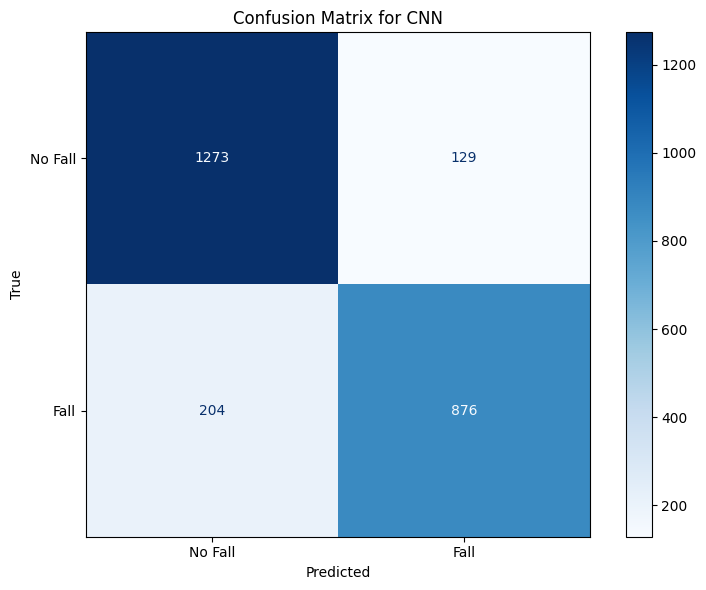

In [59]:
# Plot confusion matrix
confusion_matrix_plot(y_test, y_pred, "Confusion Matrix for CNN")

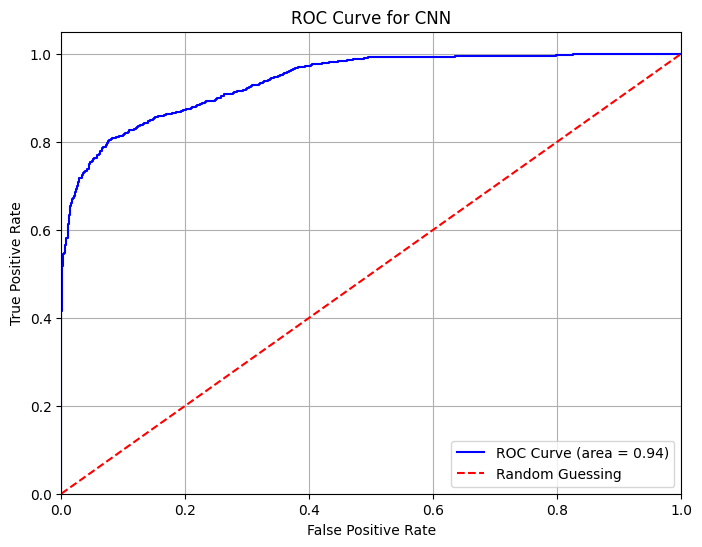

In [60]:
# Plot ROC curve
roc_curve_plot(y_test, y_pred_prob, "ROC Curve for CNN")

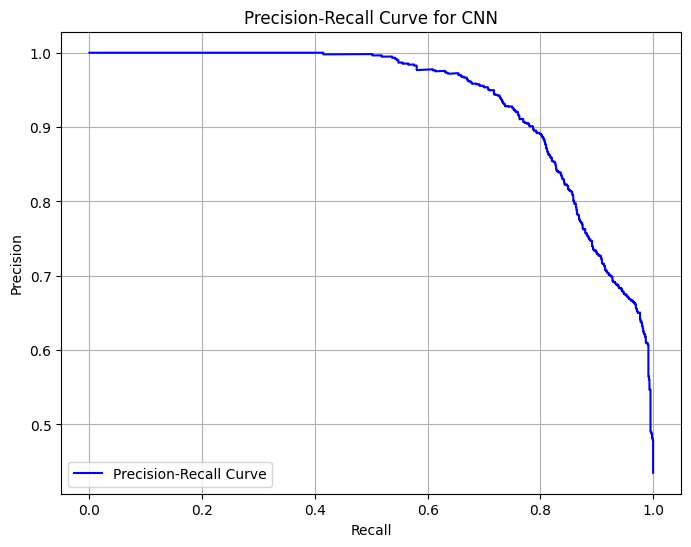

In [61]:
# Plot Recall-Precision curve
precision_recall_plot(y_test, y_pred_prob, "Precision-Recall Curve for CNN")

In [62]:
# Save the model
cnn_model.save('cnn_model.keras')

## Long Short-Term Memory (LSTM)

An LSTM-based model was implemented to explicitly capture temporal dependencies in sensor data due to its capability of managing long-range sequences.
LSTM Layers: Multiple stacked LSTM layers were configured to learn complex sequential patterns, handling potential vanishing gradient problems inherent in traditional RNNs.

- Dropout Layers: Regularized intermediate layers to reduce overfitting.
- Dense Layers: Integrated to interpret the temporal features extracted by the LSTM units.
- Output Layer: A sigmoid activation function provided binary predictions distinguishing falls from non-falls.

Hyperparameter optimization was similarly conducted to tune hidden units, learning rate, dropout rates, and batch size.

In [12]:
def build_lstm_model(input_shape, num_classes=1, hp=None):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))

    model.add(layers.LSTM(units=hp['lstm_units'], return_sequences=hp['return_sequences']))
    if hp['return_sequences']:
        model.add(layers.LSTM(units=hp['lstm_units2']))

    model.add(layers.Dropout(hp['dropout']))
    model.add(layers.Dense(hp['dense_units'], activation='relu'))
    model.add(layers.Dense(num_classes, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp['lr']),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [24]:
def objective_lstm(trial):
    hp = {
        'lstm_units': trial.suggest_int('lstm_units', 32, 128),
        'return_sequences': trial.suggest_categorical('return_sequences', [True, False]),
        'lstm_units2': trial.suggest_int('lstm_units2', 32, 128),
        'dense_units': trial.suggest_int('dense_units', 32, 128),
        'dropout': trial.suggest_float('dropout', 0.2, 0.5),
        'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    }

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_tr), y=y_tr)
        class_weight_dict = dict(enumerate(class_weights))

        model = build_lstm_model(X_tr.shape[1:], num_classes=1, hp=hp)

        early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        model.fit(X_tr, y_tr, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1,
                  class_weight=class_weight_dict, validation_data=(X_val, y_val),
                  callbacks=[early_stop])

        y_val_pred = (model.predict(X_val).flatten() > 0.5).astype(int)
        scores.append(f1_score(y_val, y_val_pred))

    return np.mean(scores)

In [25]:
lstm_study = optuna.create_study(direction='maximize')
lstm_study.optimize(objective_lstm, n_trials=N_TRIALS)

[I 2025-05-07 14:52:50,709] A new study created in memory with name: no-name-b80cdd81-2ec2-4c83-b911-3dd78f22f5af


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.8121 - loss: 0.4661 - val_accuracy: 0.8122 - val_loss: 0.4588
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.8035 - loss: 0.4742 - val_accuracy: 0.8488 - val_loss: 0.3896
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.8012 - loss: 0.4826 - val_accuracy: 0.8482 - val_loss: 0.4063
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.8198 - loss: 0.4347 - val_accuracy: 0.6224 - val_loss: 0.6476
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.7573 - loss: 0.5223 - val_accuracy: 0.8287 - val_loss: 0.4541
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.8009 - loss: 0.4819 - val_accuracy: 0.8509 - val_loss: 0.4507
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.8440 - loss: 0.4421 - val_accuracy: 0.8542 - val_loss: 0.3798
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step 

[I 2025-05-07 14:55:47,707] Trial 0 finished with value: 0.8142368647503302 and parameters: {'lstm_units': 118, 'return_sequences': True, 'lstm_units2': 66, 'dense_units': 122, 'dropout': 0.27937118056512905, 'lr': 0.006745848170340019}. Best is trial 0 with value: 0.8142368647503302.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.6626 - loss: 0.6499 - val_accuracy: 0.7606 - val_loss: 0.5490
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7726 - loss: 0.5280 - val_accuracy: 0.7810 - val_loss: 0.4740
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7906 - loss: 0.4691 - val_accuracy: 0.8344 - val_loss: 0.4288
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8386 - loss: 0.4279 - val_accuracy: 0.8503 - val_loss: 0.4097
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8519 - loss: 0.4099 - val_accuracy: 0.8497 - val_loss: 0.4025
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8523 - loss: 0.4026 - val_accuracy: 0.8515 - val_loss: 0.3952
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8525 - loss: 0.4036 - val_accuracy: 0.8506 - val_loss: 0.3918
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8612 - loss: 0.3818 - val_accu

[I 2025-05-07 14:59:06,548] Trial 1 finished with value: 0.8362397454663597 and parameters: {'lstm_units': 49, 'return_sequences': False, 'lstm_units2': 49, 'dense_units': 89, 'dropout': 0.47459862003572756, 'lr': 0.00013455947722196737}. Best is trial 1 with value: 0.8362397454663597.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8032 - loss: 0.4747 - val_accuracy: 0.8545 - val_loss: 0.3894
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8390 - loss: 0.4311 - val_accuracy: 0.8488 - val_loss: 0.3926
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8476 - loss: 0.4178 - val_accuracy: 0.8329 - val_loss: 0.4231
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8171 - loss: 0.4559 - val_accuracy: 0.8452 - val_loss: 0.4095
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7431 - loss: 0.5345 - val_accuracy: 0.8512 - val_loss: 0.4063
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8385 - loss: 0.4164 - val_accuracy: 0.8524 - val_loss: 0.3680
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8389 - loss: 0.4035 - val_accuracy: 0.8599 - val_loss: 0.3567
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - 

[I 2025-05-07 15:00:48,822] Trial 2 finished with value: 0.8221915576072448 and parameters: {'lstm_units': 107, 'return_sequences': False, 'lstm_units2': 48, 'dense_units': 56, 'dropout': 0.4017334364417998, 'lr': 0.00801265327576126}. Best is trial 1 with value: 0.8362397454663597.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.7920 - loss: 0.4768 - val_accuracy: 0.8551 - val_loss: 0.3737
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.8620 - loss: 0.3881 - val_accuracy: 0.8587 - val_loss: 0.3643
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.8694 - loss: 0.3558 - val_accuracy: 0.8551 - val_loss: 0.3645
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.8696 - loss: 0.3429 - val_accuracy: 0.8551 - val_loss: 0.3704
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.8701 - loss: 0.3540 - val_accuracy: 0.8581 - val_loss: 0.3582
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.8664 - loss: 0.3533 - val_accuracy: 0.8599 - val_loss: 0.3726
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.8712 - loss: 0.3420 - val_accuracy: 0.8647 - val_loss: 0.3507
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.8663 - loss: 0.3325 - val_acc

[I 2025-05-07 15:05:11,275] Trial 3 finished with value: 0.8327386474415098 and parameters: {'lstm_units': 81, 'return_sequences': True, 'lstm_units2': 34, 'dense_units': 63, 'dropout': 0.3252458048504711, 'lr': 0.003105001134108894}. Best is trial 1 with value: 0.8362397454663597.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.7470 - loss: 0.5444 - val_accuracy: 0.8527 - val_loss: 0.4068
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.8549 - loss: 0.4066 - val_accuracy: 0.8578 - val_loss: 0.3736
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.8639 - loss: 0.3602 - val_accuracy: 0.8620 - val_loss: 0.3575
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.8655 - loss: 0.3493 - val_accuracy: 0.8632 - val_loss: 0.3446
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.8706 - loss: 0.3225 - val_accuracy: 0.8629 - val_loss: 0.3461
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.8746 - loss: 0.3223 - val_accuracy: 0.8638 - val_loss: 0.3350
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.8766 - loss: 0.3090 - val_accuracy: 0.8620 - val_loss: 0.3367
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.8637 - loss: 0.3541 - val_acc

[I 2025-05-07 15:08:24,109] Trial 4 finished with value: 0.8389660202234056 and parameters: {'lstm_units': 72, 'return_sequences': True, 'lstm_units2': 110, 'dense_units': 74, 'dropout': 0.3327574857790587, 'lr': 0.0002762903032644522}. Best is trial 4 with value: 0.8389660202234056.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.7679 - loss: 0.5136 - val_accuracy: 0.8506 - val_loss: 0.3964
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.8546 - loss: 0.3934 - val_accuracy: 0.8605 - val_loss: 0.3502
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.8696 - loss: 0.3478 - val_accuracy: 0.8602 - val_loss: 0.3466
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8759 - loss: 0.3242 - val_accuracy: 0.8602 - val_loss: 0.3512
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.8608 - loss: 0.3344 - val_accuracy: 0.8590 - val_loss: 0.3462
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8765 - loss: 0.3199 - val_accuracy: 0.8512 - val_loss: 0.3505
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.8718 - loss: 0.3213 - val_accuracy: 0.8587 - val_loss: 0.3418
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.8712 - loss: 0.3104 - val_acc

[I 2025-05-07 15:11:33,764] Trial 5 finished with value: 0.8366369488845787 and parameters: {'lstm_units': 82, 'return_sequences': True, 'lstm_units2': 41, 'dense_units': 112, 'dropout': 0.47091163288254784, 'lr': 0.0010239922048622331}. Best is trial 4 with value: 0.8389660202234056.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.6716 - loss: 0.6620 - val_accuracy: 0.7759 - val_loss: 0.5663
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7708 - loss: 0.5492 - val_accuracy: 0.7924 - val_loss: 0.4831
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.7958 - loss: 0.4837 - val_accuracy: 0.8224 - val_loss: 0.4388
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8281 - loss: 0.4488 - val_accuracy: 0.8395 - val_loss: 0.4201
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8466 - loss: 0.4191 - val_accuracy: 0.8401 - val_loss: 0.4136
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8520 - loss: 0.4106 - val_accuracy: 0.8416 - val_loss: 0.4099
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8458 - loss: 0.4181 - val_accuracy: 0.8416 - val_loss: 0.4093
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8485 - loss: 0.4130 - val_accu

[I 2025-05-07 15:15:35,871] Trial 6 finished with value: 0.8280307730584715 and parameters: {'lstm_units': 39, 'return_sequences': False, 'lstm_units2': 117, 'dense_units': 87, 'dropout': 0.2907445901706369, 'lr': 0.00013115155379552892}. Best is trial 4 with value: 0.8389660202234056.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8055 - loss: 0.4766 - val_accuracy: 0.8518 - val_loss: 0.3868
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8518 - loss: 0.3884 - val_accuracy: 0.8443 - val_loss: 0.3953
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8387 - loss: 0.4252 - val_accuracy: 0.8485 - val_loss: 0.3702
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8414 - loss: 0.4151 - val_accuracy: 0.8503 - val_loss: 0.3817
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8516 - loss: 0.4089 - val_accuracy: 0.8476 - val_loss: 0.3716
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8565 - loss: 0.3860 - val_accuracy: 0.8560 - val_loss: 0.3615
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8615 - loss: 0.3665 - val_accuracy: 0.8491 - val_loss: 0.4080
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8531 - loss: 0.3884 - val_accu

[I 2025-05-07 15:18:09,864] Trial 7 finished with value: 0.8353918834571022 and parameters: {'lstm_units': 115, 'return_sequences': False, 'lstm_units2': 55, 'dense_units': 126, 'dropout': 0.4524110045926645, 'lr': 0.004829382004971779}. Best is trial 4 with value: 0.8389660202234056.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.7524 - loss: 0.5325 - val_accuracy: 0.8437 - val_loss: 0.4094
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8537 - loss: 0.3976 - val_accuracy: 0.8545 - val_loss: 0.3742
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8649 - loss: 0.3657 - val_accuracy: 0.8560 - val_loss: 0.3684
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8679 - loss: 0.3546 - val_accuracy: 0.8656 - val_loss: 0.3409
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8742 - loss: 0.3279 - val_accuracy: 0.8635 - val_loss: 0.3399
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8612 - loss: 0.3425 - val_accuracy: 0.8671 - val_loss: 0.3396
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8691 - loss: 0.3278 - val_accuracy: 0.8686 - val_loss: 0.3379
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8782 - loss: 0.3204 - val_accu

[I 2025-05-07 15:20:34,452] Trial 8 finished with value: 0.8414158824473202 and parameters: {'lstm_units': 40, 'return_sequences': False, 'lstm_units2': 114, 'dense_units': 128, 'dropout': 0.3252804111373505, 'lr': 0.0011488807887577734}. Best is trial 8 with value: 0.8414158824473202.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.6280 - loss: 0.6223 - val_accuracy: 0.7999 - val_loss: 0.4582
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8262 - loss: 0.4497 - val_accuracy: 0.8485 - val_loss: 0.4089
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8486 - loss: 0.4180 - val_accuracy: 0.8539 - val_loss: 0.3923
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8596 - loss: 0.3851 - val_accuracy: 0.8572 - val_loss: 0.3723
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8623 - loss: 0.3729 - val_accuracy: 0.8596 - val_loss: 0.3592
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8705 - loss: 0.3502 - val_accuracy: 0.8626 - val_loss: 0.3598
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8755 - loss: 0.3295 - val_accuracy: 0.8626 - val_loss: 0.3451
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8748 - loss: 0.3268 - val_accu

[I 2025-05-07 15:24:00,457] Trial 9 finished with value: 0.8389329599338242 and parameters: {'lstm_units': 110, 'return_sequences': False, 'lstm_units2': 65, 'dense_units': 119, 'dropout': 0.4789756602197019, 'lr': 0.00014938370070308968}. Best is trial 8 with value: 0.8414158824473202.


In [26]:
# Get the best hyperparameters
best_lstm_params = lstm_study.best_params
print("Best LSTM hyperparameters:", best_lstm_params)

Best LSTM hyperparameters: {'lstm_units': 40, 'return_sequences': False, 'lstm_units2': 114, 'dense_units': 128, 'dropout': 0.3252804111373505, 'lr': 0.0011488807887577734}


In [13]:
lstm_model = build_lstm_model(X_train.shape[1:], num_classes=1, hp=best_lstm_params)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

early_stop_final = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lstm_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1,
               class_weight=class_weight_dict, validation_split=0.2,
               callbacks=[early_stop_final])

I0000 00:00:1746735110.238070      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746735110.238726      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/50


I0000 00:00:1746735115.506261      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.7801 - loss: 0.5060 - val_accuracy: 0.7406 - val_loss: 0.5023
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8665 - loss: 0.3868 - val_accuracy: 0.7276 - val_loss: 0.5634
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8757 - loss: 0.3598 - val_accuracy: 0.7301 - val_loss: 0.6162
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8747 - loss: 0.3484 - val_accuracy: 0.7921 - val_loss: 0.4533
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8807 - loss: 0.3324 - val_accuracy: 0.7771 - val_loss: 0.5204
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8868 - loss: 0.3169 - val_accuracy: 0.7061 - val_loss: 0.5679
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8792 - loss: 0.3193 - val_accuracy: 0.7906 - val_loss: 0.4656
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8793 - loss: 0.3099 - val_accuracy: 0.799

In [14]:
y_pred_prob = lstm_model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [15]:
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred_prob)

print("LSTM Test Accuracy:", test_accuracy)
print("LSTM Test Precision:", test_precision)
print("LSTM Test Recall:", test_recall)
print("LSTM Test F1-score:", test_f1)
print("LSTM Test AUC:", test_auc)

LSTM Test Accuracy: 0.871071716357776
LSTM Test Precision: 0.9051172707889126
LSTM Test Recall: 0.7861111111111111
LSTM Test F1-score: 0.8414271555996036
LSTM Test AUC: 0.9292095947588102


In [30]:
# Visualize optuna results
optuna_visualizations(lstm_study, ['lstm_units', 'return_sequences', 'dense_units', 'dropout', 'lr'])

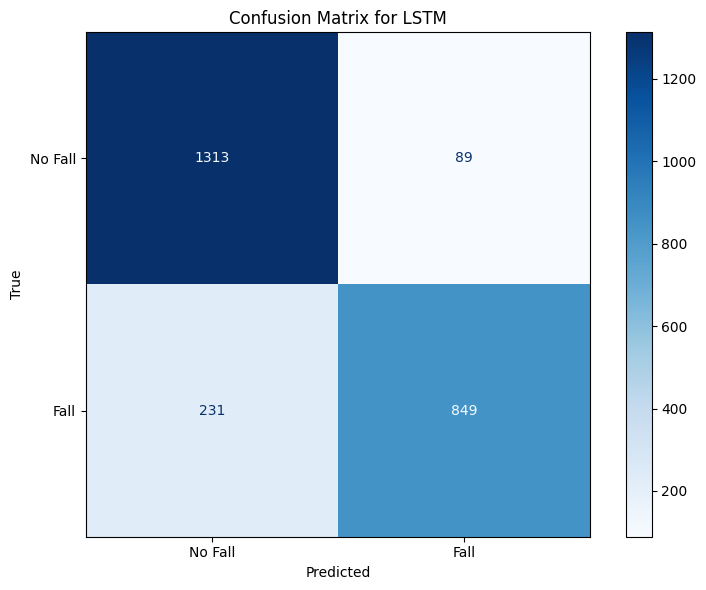

In [16]:
# Plot confusion matrix
confusion_matrix_plot(y_test, y_pred, "Confusion Matrix for LSTM")

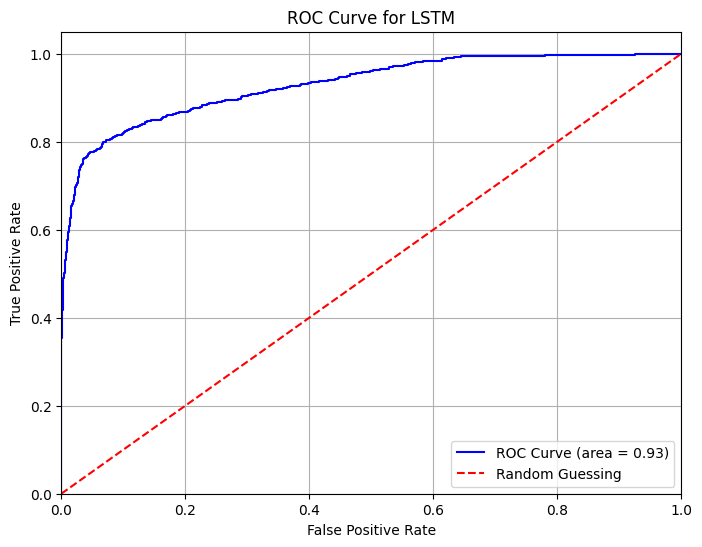

In [17]:
# Plot ROC curve
roc_curve_plot(y_test, y_pred_prob, "ROC Curve for LSTM")

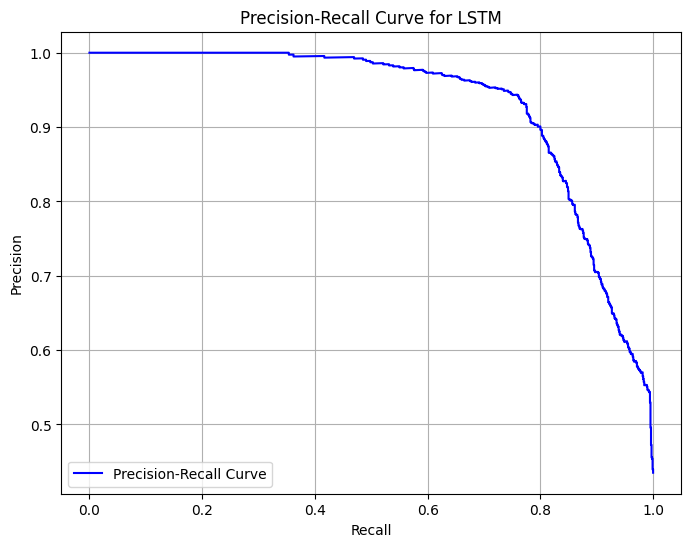

In [18]:
# Plot Recall-Precision curve
precision_recall_plot(y_test, y_pred_prob, "Precision-Recall Curve for LSTM")

In [19]:
# Save the model
lstm_model.save('lstm_model.keras')

## Hybrid Model (CNN-LSTM)

The hybrid CNN-LSTM architecture integrates the strengths of convolutional and recurrent layers. CNN layers initially extract meaningful spatial-temporal features, while subsequent LSTM layers model sequential dependencies from these features.

- Convolutional Layers: Extract initial local patterns and reduce sequence complexity.
- LSTM Layers: Analyze extracted features to capture temporal context and dependencies effectively.
- Fully Connected Layers: Provide an abstraction of temporal patterns.
- Output Layer: Binary output indicating fall or non-fall events.

Optuna optimized both CNN and LSTM hyperparameters to ensure balanced performance of both model components.

In [71]:
def build_cnn_lstm_model(input_shape, num_classes=1, hp=None):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))

    model.add(layers.Conv1D(filters=hp['filters'], kernel_size=hp['kernel_size'], activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.LSTM(units=hp['lstm_units']))

    model.add(layers.Dropout(hp['dropout']))
    model.add(layers.Dense(hp['dense_units'], activation='relu'))
    model.add(layers.Dense(num_classes, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp['lr']),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [36]:
def objective_cnn_lstm(trial):
    hp = {
        'filters': trial.suggest_categorical('filters', [16, 32, 64]),
        'kernel_size': trial.suggest_categorical('kernel_size', [3, 5, 7]),
        'lstm_units': trial.suggest_int('lstm_units', 32, 128),
        'dense_units': trial.suggest_int('dense_units', 32, 128),
        'dropout': trial.suggest_float('dropout', 0.2, 0.5),
        'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    }

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_tr), y=y_tr)
        class_weight_dict = dict(enumerate(class_weights))

        model = build_cnn_lstm_model(X_tr.shape[1:], num_classes=1, hp=hp)

        early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        model.fit(X_tr, y_tr, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1,
                  class_weight=class_weight_dict, validation_data=(X_val, y_val),
                  callbacks=[early_stop])

        y_val_pred = (model.predict(X_val).flatten() > 0.5).astype(int)
        scores.append(f1_score(y_val, y_val_pred))

    return np.mean(scores)

In [37]:
cnn_lstm_study = optuna.create_study(direction='maximize')
cnn_lstm_study.optimize(objective_cnn_lstm, n_trials=N_TRIALS)

[I 2025-05-07 15:24:46,461] A new study created in memory with name: no-name-dcf578df-c402-4412-b709-e2bc51c9c14e


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.8043 - loss: 0.4663 - val_accuracy: 0.8407 - val_loss: 0.3872
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8581 - loss: 0.3902 - val_accuracy: 0.8599 - val_loss: 0.3570
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8665 - loss: 0.3543 - val_accuracy: 0.8629 - val_loss: 0.3320
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8742 - loss: 0.3299 - val_accuracy: 0.8509 - val_loss: 0.3480
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8601 - loss: 0.3563 - val_accuracy: 0.8656 - val_loss: 0.3334
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8649 - loss: 0.3372 - val_accuracy: 0.8692 - val_loss: 0.3208
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8584 - loss: 0.3351 - val_accuracy: 0.8560 - val_loss: 0.3406
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8379 - loss: 0.3785 - val_accu

[I 2025-05-07 15:26:41,817] Trial 0 finished with value: 0.8662519400482681 and parameters: {'filters': 32, 'kernel_size': 7, 'lstm_units': 68, 'dense_units': 90, 'dropout': 0.45349152357075906, 'lr': 0.005974035846914434}. Best is trial 0 with value: 0.8662519400482681.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6413 - loss: 0.6115 - val_accuracy: 0.8503 - val_loss: 0.3911
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8561 - loss: 0.3854 - val_accuracy: 0.8566 - val_loss: 0.3611
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8622 - loss: 0.3536 - val_accuracy: 0.8596 - val_loss: 0.3556
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8672 - loss: 0.3365 - val_accuracy: 0.8602 - val_loss: 0.3389
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8572 - loss: 0.3560 - val_accuracy: 0.8617 - val_loss: 0.3333
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8748 - loss: 0.3167 - val_accuracy: 0.8593 - val_loss: 0.3525
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8738 - loss: 0.3219 - val_accuracy: 0.8650 - val_loss: 0.3156
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8652 - loss: 0.3241 - val_accu

[I 2025-05-07 15:27:50,022] Trial 1 finished with value: 0.8418328370229528 and parameters: {'filters': 32, 'kernel_size': 3, 'lstm_units': 66, 'dense_units': 109, 'dropout': 0.22327438791885734, 'lr': 0.00022802551229883072}. Best is trial 0 with value: 0.8662519400482681.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7421 - loss: 0.5614 - val_accuracy: 0.8536 - val_loss: 0.3840
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8593 - loss: 0.3750 - val_accuracy: 0.8611 - val_loss: 0.3565
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8626 - loss: 0.3501 - val_accuracy: 0.8599 - val_loss: 0.3501
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8703 - loss: 0.3419 - val_accuracy: 0.8626 - val_loss: 0.3450
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8611 - loss: 0.3480 - val_accuracy: 0.8638 - val_loss: 0.3333
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8758 - loss: 0.3168 - val_accuracy: 0.8623 - val_loss: 0.3395
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8749 - loss: 0.3142 - val_accuracy: 0.8638 - val_loss: 0.3240
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8573 - loss: 0.3282 - val_accu

[I 2025-05-07 15:29:30,824] Trial 2 finished with value: 0.8444888584373302 and parameters: {'filters': 64, 'kernel_size': 5, 'lstm_units': 106, 'dense_units': 102, 'dropout': 0.49507842458923357, 'lr': 0.00022361050643246796}. Best is trial 0 with value: 0.8662519400482681.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8023 - loss: 0.4682 - val_accuracy: 0.8527 - val_loss: 0.3897
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8562 - loss: 0.3873 - val_accuracy: 0.8599 - val_loss: 0.3794
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8503 - loss: 0.3798 - val_accuracy: 0.8650 - val_loss: 0.3454
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8679 - loss: 0.3750 - val_accuracy: 0.8572 - val_loss: 0.3570
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8712 - loss: 0.3428 - val_accuracy: 0.8644 - val_loss: 0.3361
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8700 - loss: 0.3391 - val_accuracy: 0.8605 - val_loss: 0.3159
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8680 - loss: 0.3304 - val_accuracy: 0.8677 - val_loss: 0.3275
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8579 - loss: 0.3376 - val_accu

[I 2025-05-07 15:31:02,800] Trial 3 finished with value: 0.8447593459172636 and parameters: {'filters': 16, 'kernel_size': 7, 'lstm_units': 83, 'dense_units': 94, 'dropout': 0.47382236137697237, 'lr': 0.0035538993664675604}. Best is trial 0 with value: 0.8662519400482681.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8090 - loss: 0.4591 - val_accuracy: 0.8590 - val_loss: 0.3536
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8673 - loss: 0.3525 - val_accuracy: 0.8608 - val_loss: 0.3479
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8695 - loss: 0.3343 - val_accuracy: 0.8497 - val_loss: 0.3533
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8683 - loss: 0.3258 - val_accuracy: 0.8650 - val_loss: 0.3274
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8749 - loss: 0.3181 - val_accuracy: 0.8521 - val_loss: 0.3269
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8666 - loss: 0.3234 - val_accuracy: 0.8416 - val_loss: 0.4051
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8536 - loss: 0.3697 - val_accuracy: 0.8617 - val_loss: 0.3410
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8565 - loss: 0.3583 - val_accu

[I 2025-05-07 15:32:37,191] Trial 4 finished with value: 0.8519430421960101 and parameters: {'filters': 64, 'kernel_size': 5, 'lstm_units': 86, 'dense_units': 112, 'dropout': 0.3360032352068125, 'lr': 0.0014913073969731578}. Best is trial 0 with value: 0.8662519400482681.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8215 - loss: 0.4352 - val_accuracy: 0.8593 - val_loss: 0.3701
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8707 - loss: 0.3514 - val_accuracy: 0.8617 - val_loss: 0.3660
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8650 - loss: 0.3548 - val_accuracy: 0.8659 - val_loss: 0.3472
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8735 - loss: 0.3379 - val_accuracy: 0.8464 - val_loss: 0.3651
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8498 - loss: 0.3678 - val_accuracy: 0.8587 - val_loss: 0.3414
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8669 - loss: 0.3323 - val_accuracy: 0.8674 - val_loss: 0.3290
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8733 - loss: 0.3104 - val_accuracy: 0.8635 - val_loss: 0.3349
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8745 - loss: 0.3071 - val_accu

[I 2025-05-07 15:34:27,406] Trial 5 finished with value: 0.8608243430631118 and parameters: {'filters': 64, 'kernel_size': 3, 'lstm_units': 68, 'dense_units': 75, 'dropout': 0.20204877524574857, 'lr': 0.002787931741954633}. Best is trial 0 with value: 0.8662519400482681.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.7588 - loss: 0.5840 - val_accuracy: 0.8503 - val_loss: 0.3921
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8489 - loss: 0.3930 - val_accuracy: 0.8530 - val_loss: 0.3738
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8662 - loss: 0.3545 - val_accuracy: 0.8596 - val_loss: 0.3549
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8632 - loss: 0.3506 - val_accuracy: 0.8455 - val_loss: 0.3742
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8572 - loss: 0.3622 - val_accuracy: 0.8560 - val_loss: 0.3536
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8641 - loss: 0.3452 - val_accuracy: 0.8572 - val_loss: 0.3418
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8749 - loss: 0.3266 - val_accuracy: 0.8575 - val_loss: 0.3482
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8706 - loss: 0.3185 - val_accu

[I 2025-05-07 15:36:07,986] Trial 6 finished with value: 0.8315291200104385 and parameters: {'filters': 16, 'kernel_size': 5, 'lstm_units': 102, 'dense_units': 43, 'dropout': 0.20056621656306695, 'lr': 0.0001026379550445231}. Best is trial 0 with value: 0.8662519400482681.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7453 - loss: 0.5895 - val_accuracy: 0.8467 - val_loss: 0.3921
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8577 - loss: 0.3822 - val_accuracy: 0.8524 - val_loss: 0.3636
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8679 - loss: 0.3367 - val_accuracy: 0.8509 - val_loss: 0.3744
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8644 - loss: 0.3493 - val_accuracy: 0.8563 - val_loss: 0.3588
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8642 - loss: 0.3502 - val_accuracy: 0.8566 - val_loss: 0.3747
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8690 - loss: 0.3425 - val_accuracy: 0.7939 - val_loss: 0.4763
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8265 - loss: 0.4156 - val_accuracy: 0.8557 - val_loss: 0.3639
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - a

[I 2025-05-07 15:37:47,085] Trial 7 finished with value: 0.8294852907948033 and parameters: {'filters': 16, 'kernel_size': 5, 'lstm_units': 128, 'dense_units': 54, 'dropout': 0.28479317851914815, 'lr': 0.0001219042354755271}. Best is trial 0 with value: 0.8662519400482681.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8153 - loss: 0.4660 - val_accuracy: 0.8521 - val_loss: 0.3863
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8592 - loss: 0.3755 - val_accuracy: 0.8563 - val_loss: 0.3858
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8641 - loss: 0.3622 - val_accuracy: 0.8626 - val_loss: 0.3407
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8706 - loss: 0.3366 - val_accuracy: 0.8599 - val_loss: 0.3419
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8715 - loss: 0.3206 - val_accuracy: 0.8590 - val_loss: 0.3490
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8702 - loss: 0.3262 - val_accuracy: 0.8644 - val_loss: 0.3335
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8615 - loss: 0.3487 - val_accuracy: 0.8614 - val_loss: 0.3447
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8685 - loss: 0.3316 - val_accu

[I 2025-05-07 15:39:06,946] Trial 8 finished with value: 0.8499574155074537 and parameters: {'filters': 16, 'kernel_size': 7, 'lstm_units': 61, 'dense_units': 37, 'dropout': 0.4990379556429685, 'lr': 0.0023231192524300493}. Best is trial 0 with value: 0.8662519400482681.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.7920 - loss: 0.4786 - val_accuracy: 0.8590 - val_loss: 0.3820
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8656 - loss: 0.3624 - val_accuracy: 0.8512 - val_loss: 0.3739
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8739 - loss: 0.3334 - val_accuracy: 0.8560 - val_loss: 0.3813
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8708 - loss: 0.3596 - val_accuracy: 0.8593 - val_loss: 0.3621
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8754 - loss: 0.3250 - val_accuracy: 0.8626 - val_loss: 0.4201
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8564 - loss: 0.3484 - val_accuracy: 0.8590 - val_loss: 0.3576
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8683 - loss: 0.3280 - val_accuracy: 0.8605 - val_loss: 0.3343
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8738 - loss: 0.3113 - val_accu

[I 2025-05-07 15:40:26,438] Trial 9 finished with value: 0.8366818335993331 and parameters: {'filters': 16, 'kernel_size': 5, 'lstm_units': 116, 'dense_units': 123, 'dropout': 0.348012680990997, 'lr': 0.0012212412901967395}. Best is trial 0 with value: 0.8662519400482681.


In [38]:
# Get the best hyperparameters
best_cnn_lstm_params = cnn_lstm_study.best_params
print("Best CNN-LSTM hyperparameters:", best_cnn_lstm_params)

Best CNN-LSTM hyperparameters: {'filters': 32, 'kernel_size': 7, 'lstm_units': 68, 'dense_units': 90, 'dropout': 0.45349152357075906, 'lr': 0.005974035846914434}


In [72]:
cnn_lstm_model = build_cnn_lstm_model(X_train.shape[1:], num_classes=1, hp=best_cnn_lstm_params)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

early_stop_final = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cnn_lstm_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1,
                   class_weight=class_weight_dict, validation_split=0.2,
                   callbacks=[early_stop_final])

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8401 - loss: 0.4377 - val_accuracy: 0.8166 - val_loss: 0.4398
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8755 - loss: 0.3610 - val_accuracy: 0.7566 - val_loss: 0.4375
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8717 - loss: 0.3604 - val_accuracy: 0.8166 - val_loss: 0.4051
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8679 - loss: 0.3473 - val_accuracy: 0.7666 - val_loss: 0.4963
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8705 - loss: 0.3529 - val_accuracy: 0.8096 - val_loss: 0.4958
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8658 - loss: 0.3495 - val_accuracy: 0.7531 - val_loss: 0.4464
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8654 - loss: 0.3738 - val_accuracy: 0.6632 - val_loss: 0.4995
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8644 - loss: 0.3692 - val_accu

In [73]:
y_pred_prob = cnn_lstm_model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [74]:
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred_prob)

print("CNN-LSTM Test Accuracy:", test_accuracy)
print("CNN-LSTM Test Precision:", test_precision)
print("CNN-LSTM Test Recall:", test_recall)
print("CNN-LSTM Test F1-score:", test_f1)
print("CNN-LSTM Test AUC:", test_auc)

CNN-LSTM Test Accuracy: 0.8779210314262691
CNN-LSTM Test Precision: 0.9264544456641054
CNN-LSTM Test Recall: 0.7814814814814814
CNN-LSTM Test F1-score: 0.8478151682571572
CNN-LSTM Test AUC: 0.9338808316162097


In [42]:
# Visualize optuna results
optuna_visualizations(cnn_lstm_study, ['filters', 'kernel_size', 'lstm_units', 'dense_units', 'dropout', 'lr'])

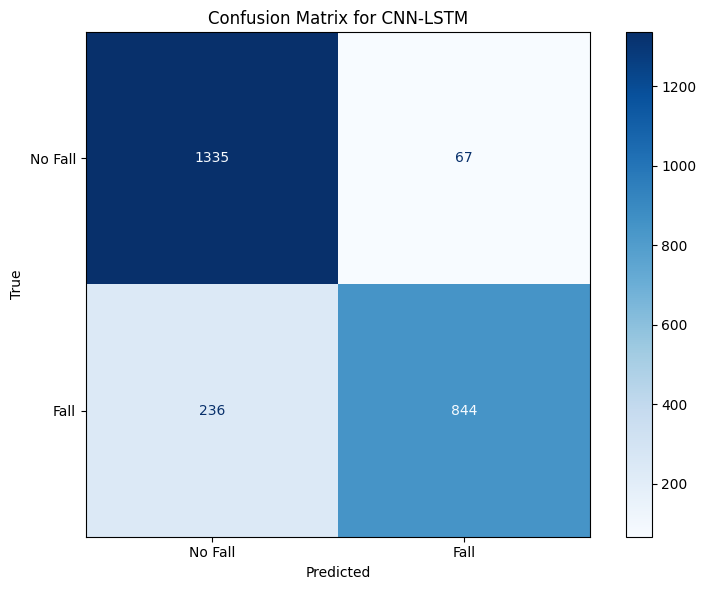

In [75]:
# Plot confusion matrix
confusion_matrix_plot(y_test, y_pred, "Confusion Matrix for CNN-LSTM")

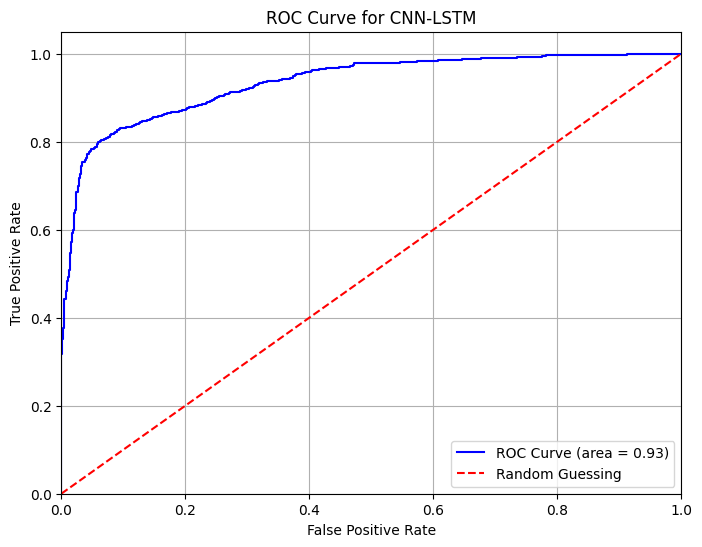

In [76]:
# Plot ROC curve
roc_curve_plot(y_test, y_pred_prob, "ROC Curve for CNN-LSTM")

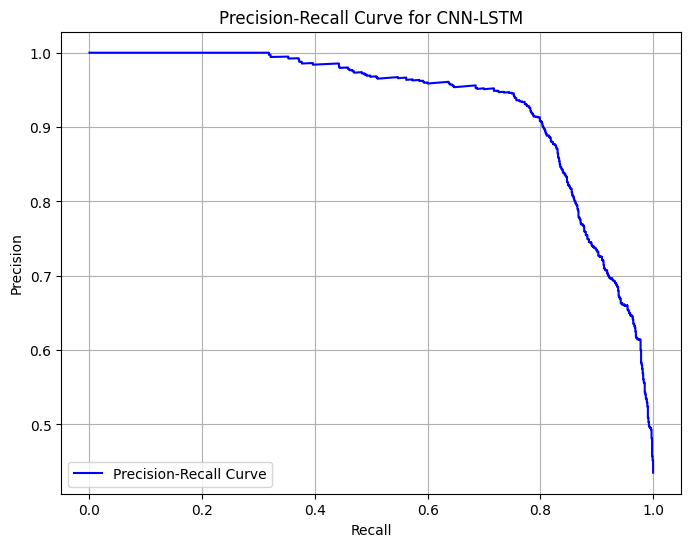

In [77]:
# Plot Recall-Precision curve
precision_recall_plot(y_test, y_pred_prob, "Precision-Recall Curve for CNN-LSTM")

In [78]:
# Save the model
cnn_lstm_model.save('cnn_lstm_model.keras')

## Transformer Model

The Transformer architecture was selected due to its effectiveness in modeling sequential data through self-attention mechanisms. Transformers allow simultaneous attention to all positions in the sequence, effectively capturing long-range dependencies and intricate temporal interactions.

- Positional Encoding: Embedded temporal positional information enabling the model to distinguish relative positioning within the sequence.
- Multi-head Self-Attention Layers: Allowed the model to focus simultaneously on multiple temporal patterns and interactions within the sensor data, capturing nuanced indicators of fall events
- Feed-Forward Neural Network Layers: Provided a means for deeper abstraction and interpretation of temporal relationships.
- Layer Normalization: Enhanced model stability during training.
- Output Layer: Sigmoid activation function performed binary classification tasks.

Hyperparameter tuning via Optuna optimized attention heads, embedding dimensions, learning rates, dropout rates, and other critical parameters, ensuring that the Transformer leveraged its attention capabilities efficiently for fall detection tasks.

In [79]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout):
    # Self-attention block
    attention_output = layers.MultiHeadAttention(
        key_dim=head_size,
        num_heads=num_heads,
        dropout=dropout
    )(inputs, inputs)
    attention_output = layers.Dropout(dropout)(attention_output)
    attention_output = layers.Add()([inputs, attention_output])  # Residual connection
    attention_output = layers.LayerNormalization(epsilon=1e-6)(attention_output)

    # Feed-forward block
    ff_output = layers.Dense(ff_dim, activation="relu")(attention_output)
    ff_output = layers.Dropout(dropout)(ff_output)
    ff_output = layers.Dense(inputs.shape[-1])(ff_output)
    ff_output = layers.Add()([attention_output, ff_output])  # Residual connection
    ff_output = layers.LayerNormalization(epsilon=1e-6)(ff_output)

    return ff_output

In [80]:
def build_transformer_model(input_shape, num_classes=1, hp=None):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    for _ in range(hp['num_transformer_blocks']):
        x = transformer_encoder(x, head_size=hp['head_size'], num_heads=hp['num_heads'], ff_dim=hp['ff_dim'],
                                dropout=hp['dropout'])

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(hp['dense_units'], activation='relu')(x)
    x = layers.Dropout(hp['dropout'])(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp['lr']),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [49]:
def objective_transformer(trial):
    hp = {
        'num_transformer_blocks': trial.suggest_int('num_transformer_blocks', 1, 3),
        'head_size': trial.suggest_categorical('head_size', [32, 64]),
        'num_heads': trial.suggest_categorical('num_heads', [2, 4]),
        'ff_dim': trial.suggest_int('ff_dim', 32, 128),
        'dense_units': trial.suggest_int('dense_units', 32, 128),
        'dropout': trial.suggest_float('dropout', 0.1, 0.5),
        'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    }

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_tr), y=y_tr)
        class_weight_dict = dict(enumerate(class_weights))

        model = build_transformer_model(X_tr.shape[1:], num_classes=1, hp=hp)

        early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        model.fit(X_tr, y_tr, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1,
                  class_weight=class_weight_dict, validation_data=(X_val, y_val),
                  callbacks=[early_stop])

        y_val_pred = (model.predict(X_val).flatten() > 0.5).astype(int)
        scores.append(f1_score(y_val, y_val_pred))

    return np.mean(scores)

In [50]:
transformer_study = optuna.create_study(direction='maximize')
transformer_study.optimize(objective_transformer, n_trials=N_TRIALS)

[I 2025-05-07 15:40:56,846] A new study created in memory with name: no-name-2fa79871-08e9-4d49-87ef-8811bbc38af7


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 40s 213ms/step - accuracy: 0.4791 - loss: 0.6809 - val_accuracy: 0.8218 - val_loss: 0.5870
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.8045 - loss: 0.5630 - val_accuracy: 0.8239 - val_loss: 0.4952
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.8227 - loss: 0.4922 - val_accuracy: 0.8278 - val_loss: 0.4616
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 0.8312 - loss: 0.4653 - val_accuracy: 0.8359 - val_loss: 0.4458
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 0.8414 - loss: 0.4426 - val_accuracy: 0.8401 - val_loss: 0.4327
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - accuracy: 0.8358 - loss: 0.4389 - val_accuracy: 0.8398 - val_loss: 0.4209
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 0.8431 - loss: 0.4185 - val_accuracy: 0.8392 - val_loss: 0.4041
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 0.8420 - loss: 0

[I 2025-05-07 16:09:51,897] Trial 0 finished with value: 0.8602180258159416 and parameters: {'num_transformer_blocks': 2, 'head_size': 64, 'num_heads': 2, 'ff_dim': 95, 'dense_units': 112, 'dropout': 0.16890239558929335, 'lr': 0.00010249471136056415}. Best is trial 0 with value: 0.8602180258159416.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 37s 205ms/step - accuracy: 0.7966 - loss: 0.4994 - val_accuracy: 0.8320 - val_loss: 0.3845
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.8377 - loss: 0.3817 - val_accuracy: 0.8401 - val_loss: 0.3550
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - accuracy: 0.8386 - loss: 0.3606 - val_accuracy: 0.8464 - val_loss: 0.3586
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 0.8509 - loss: 0.3309 - val_accuracy: 0.8521 - val_loss: 0.3309
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.8665 - loss: 0.3091 - val_accuracy: 0.8638 - val_loss: 0.2993
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.8718 - loss: 0.2924 - val_accuracy: 0.8602 - val_loss: 0.3192
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.8870 - loss: 0.2787 - val_accuracy: 0.8638 - val_loss: 0.2847
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - accuracy: 0.8780 - loss: 0

[I 2025-05-07 16:21:49,218] Trial 1 finished with value: 0.8772500869698985 and parameters: {'num_transformer_blocks': 2, 'head_size': 64, 'num_heads': 2, 'ff_dim': 114, 'dense_units': 101, 'dropout': 0.16640994086932262, 'lr': 0.002224420126588165}. Best is trial 1 with value: 0.8772500869698985.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 29s 158ms/step - accuracy: 0.7800 - loss: 0.5775 - val_accuracy: 0.8344 - val_loss: 0.4424
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.8431 - loss: 0.4169 - val_accuracy: 0.8386 - val_loss: 0.3838
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.8329 - loss: 0.3866 - val_accuracy: 0.8419 - val_loss: 0.3557
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.8360 - loss: 0.3685 - val_accuracy: 0.8470 - val_loss: 0.3518
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.8423 - loss: 0.3477 - val_accuracy: 0.8500 - val_loss: 0.3330
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.8484 - loss: 0.3322 - val_accuracy: 0.8440 - val_loss: 0.3265
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.8543 - loss: 0.3183 - val_accuracy: 0.8497 - val_loss: 0.3042
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.8684 - loss: 0.29

[I 2025-05-07 16:32:27,987] Trial 2 finished with value: 0.8575617681413469 and parameters: {'num_transformer_blocks': 1, 'head_size': 32, 'num_heads': 4, 'ff_dim': 120, 'dense_units': 109, 'dropout': 0.17970291480395695, 'lr': 0.0006391672477979759}. Best is trial 1 with value: 0.8772500869698985.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 80s 522ms/step - accuracy: 0.7857 - loss: 0.5245 - val_accuracy: 0.8326 - val_loss: 0.4199
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 390ms/step - accuracy: 0.8197 - loss: 0.4236 - val_accuracy: 0.8425 - val_loss: 0.3676
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 395ms/step - accuracy: 0.8361 - loss: 0.3648 - val_accuracy: 0.8485 - val_loss: 0.3512
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 393ms/step - accuracy: 0.8484 - loss: 0.3351 - val_accuracy: 0.8611 - val_loss: 0.3103
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 394ms/step - accuracy: 0.8539 - loss: 0.3215 - val_accuracy: 0.8566 - val_loss: 0.3140
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 393ms/step - accuracy: 0.8614 - loss: 0.2953 - val_accuracy: 0.8755 - val_loss: 0.2805
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 394ms/step - accuracy: 0.8699 - loss: 0.2878 - val_accuracy: 0.8758 - val_loss: 0.2776
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 394ms/step - accuracy: 0.8797 - loss: 0

[I 2025-05-07 17:09:05,703] Trial 3 finished with value: 0.8832101199342434 and parameters: {'num_transformer_blocks': 3, 'head_size': 64, 'num_heads': 4, 'ff_dim': 109, 'dense_units': 75, 'dropout': 0.19865014266208783, 'lr': 0.0012671914806449372}. Best is trial 3 with value: 0.8832101199342434.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 62s 408ms/step - accuracy: 0.8102 - loss: 0.4861 - val_accuracy: 0.8464 - val_loss: 0.4136
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 32s 302ms/step - accuracy: 0.8347 - loss: 0.4133 - val_accuracy: 0.8218 - val_loss: 0.3814
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 32s 301ms/step - accuracy: 0.8534 - loss: 0.3357 - val_accuracy: 0.8464 - val_loss: 0.3317
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 32s 303ms/step - accuracy: 0.8437 - loss: 0.3448 - val_accuracy: 0.8347 - val_loss: 0.3376
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 32s 302ms/step - accuracy: 0.8610 - loss: 0.3204 - val_accuracy: 0.8452 - val_loss: 0.3329
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 32s 302ms/step - accuracy: 0.8645 - loss: 0.3200 - val_accuracy: 0.8407 - val_loss: 0.3274
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 32s 302ms/step - accuracy: 0.8758 - loss: 0.2781 - val_accuracy: 0.8479 - val_loss: 0.3218
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 32s 302ms/step - accuracy: 0.8697 - loss: 0

[I 2025-05-07 17:33:14,827] Trial 4 finished with value: 0.8515474048352125 and parameters: {'num_transformer_blocks': 3, 'head_size': 32, 'num_heads': 4, 'ff_dim': 106, 'dense_units': 119, 'dropout': 0.2721506777562367, 'lr': 0.0034604536715050734}. Best is trial 3 with value: 0.8832101199342434.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 53s 295ms/step - accuracy: 0.7281 - loss: 0.6284 - val_accuracy: 0.8188 - val_loss: 0.4857
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 22s 211ms/step - accuracy: 0.8219 - loss: 0.4948 - val_accuracy: 0.8305 - val_loss: 0.4379
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 200ms/step - accuracy: 0.8338 - loss: 0.4434 - val_accuracy: 0.8374 - val_loss: 0.4034
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 191ms/step - accuracy: 0.8367 - loss: 0.4193 - val_accuracy: 0.8356 - val_loss: 0.3915
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - accuracy: 0.8420 - loss: 0.3839 - val_accuracy: 0.8419 - val_loss: 0.3785
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - accuracy: 0.8421 - loss: 0.3847 - val_accuracy: 0.8464 - val_loss: 0.3764
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - accuracy: 0.8385 - loss: 0.3809 - val_accuracy: 0.8437 - val_loss: 0.3644
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 197ms/step - accuracy: 0.8515 - loss: 0

[I 2025-05-07 18:01:32,599] Trial 5 finished with value: 0.8497918290820458 and parameters: {'num_transformer_blocks': 3, 'head_size': 64, 'num_heads': 2, 'ff_dim': 102, 'dense_units': 80, 'dropout': 0.2882067696018603, 'lr': 0.00017639950827065976}. Best is trial 3 with value: 0.8832101199342434.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 50s 258ms/step - accuracy: 0.6816 - loss: 0.6565 - val_accuracy: 0.8122 - val_loss: 0.5036
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 170ms/step - accuracy: 0.8181 - loss: 0.5022 - val_accuracy: 0.8266 - val_loss: 0.4533
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - accuracy: 0.8307 - loss: 0.4640 - val_accuracy: 0.8380 - val_loss: 0.4201
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 0.8403 - loss: 0.4180 - val_accuracy: 0.8368 - val_loss: 0.3986
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 0.8367 - loss: 0.4004 - val_accuracy: 0.8467 - val_loss: 0.3774
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 0.8390 - loss: 0.3902 - val_accuracy: 0.8500 - val_loss: 0.3684
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - accuracy: 0.8460 - loss: 0.3767 - val_accuracy: 0.8536 - val_loss: 0.3548
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - accuracy: 0.8553 - loss: 0

[I 2025-05-07 18:18:50,764] Trial 6 finished with value: 0.8419397058122596 and parameters: {'num_transformer_blocks': 3, 'head_size': 32, 'num_heads': 2, 'ff_dim': 123, 'dense_units': 80, 'dropout': 0.3695772227356998, 'lr': 0.0001492274555173143}. Best is trial 3 with value: 0.8832101199342434.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 51s 345ms/step - accuracy: 0.8082 - loss: 0.5001 - val_accuracy: 0.8305 - val_loss: 0.4494
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 268ms/step - accuracy: 0.8204 - loss: 0.4611 - val_accuracy: 0.8398 - val_loss: 0.4340
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 255ms/step - accuracy: 0.8490 - loss: 0.4406 - val_accuracy: 0.8350 - val_loss: 0.4405
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 255ms/step - accuracy: 0.8440 - loss: 0.4414 - val_accuracy: 0.8398 - val_loss: 0.4337
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 261ms/step - accuracy: 0.8490 - loss: 0.4353 - val_accuracy: 0.8398 - val_loss: 0.4427
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 259ms/step - accuracy: 0.8514 - loss: 0.4299 - val_accuracy: 0.8443 - val_loss: 0.4245
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 255ms/step - accuracy: 0.8495 - loss: 0.4311 - val_accuracy: 0.8350 - val_loss: 0.4442
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 255ms/step - accuracy: 0.8421 - loss: 0

[I 2025-05-07 18:30:46,830] Trial 7 finished with value: 0.8012238075690883 and parameters: {'num_transformer_blocks': 2, 'head_size': 64, 'num_heads': 4, 'ff_dim': 104, 'dense_units': 110, 'dropout': 0.4655653539822354, 'lr': 0.008457985024708143}. Best is trial 3 with value: 0.8832101199342434.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 35s 177ms/step - accuracy: 0.7124 - loss: 0.5766 - val_accuracy: 0.8416 - val_loss: 0.3898
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 107ms/step - accuracy: 0.8436 - loss: 0.3773 - val_accuracy: 0.8356 - val_loss: 0.3588
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 0.8444 - loss: 0.3517 - val_accuracy: 0.8545 - val_loss: 0.3258
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.8491 - loss: 0.3226 - val_accuracy: 0.8563 - val_loss: 0.3179
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.8614 - loss: 0.3046 - val_accuracy: 0.8548 - val_loss: 0.3160
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.8519 - loss: 0.3084 - val_accuracy: 0.8587 - val_loss: 0.2967
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.8583 - loss: 0.2955 - val_accuracy: 0.8656 - val_loss: 0.2822
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.8627 - loss: 0

[I 2025-05-07 18:40:23,608] Trial 8 finished with value: 0.87003087124525 and parameters: {'num_transformer_blocks': 2, 'head_size': 32, 'num_heads': 2, 'ff_dim': 117, 'dense_units': 97, 'dropout': 0.19685083380924862, 'lr': 0.0008997991300380994}. Best is trial 3 with value: 0.8832101199342434.


Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 35s 175ms/step - accuracy: 0.7872 - loss: 0.5054 - val_accuracy: 0.8353 - val_loss: 0.3679
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.8428 - loss: 0.3537 - val_accuracy: 0.8473 - val_loss: 0.3465
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - accuracy: 0.8508 - loss: 0.3394 - val_accuracy: 0.8575 - val_loss: 0.3222
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - accuracy: 0.8694 - loss: 0.3055 - val_accuracy: 0.8641 - val_loss: 0.2958
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - accuracy: 0.8676 - loss: 0.2880 - val_accuracy: 0.8665 - val_loss: 0.2882
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.8701 - loss: 0.2948 - val_accuracy: 0.8761 - val_loss: 0.2784
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - accuracy: 0.8697 - loss: 0.2863 - val_accuracy: 0.8740 - val_loss: 0.2761
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.8762 - loss: 0

[I 2025-05-07 18:51:25,686] Trial 9 finished with value: 0.8804229452045682 and parameters: {'num_transformer_blocks': 2, 'head_size': 32, 'num_heads': 2, 'ff_dim': 107, 'dense_units': 52, 'dropout': 0.2582819661452451, 'lr': 0.0024621174307994545}. Best is trial 3 with value: 0.8832101199342434.


In [51]:
# Get the best hyperparameters
best_transformer_params = transformer_study.best_params
print("Best Transformer hyperparameters:", best_transformer_params)

Best Transformer hyperparameters: {'num_transformer_blocks': 3, 'head_size': 64, 'num_heads': 4, 'ff_dim': 109, 'dense_units': 75, 'dropout': 0.19865014266208783, 'lr': 0.0012671914806449372}


In [81]:
transformer_model = build_transformer_model(X_train.shape[1:], num_classes=1, hp=best_transformer_params)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

early_stop_final = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
transformer_model.fit(X_train, y_train, epochs=20, batch_size=BATCH_SIZE, verbose=1,
                      class_weight=class_weight_dict, validation_split=0.2,
                      callbacks=[early_stop_final])

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 77s 423ms/step - accuracy: 0.8183 - loss: 0.4707 - val_accuracy: 0.7521 - val_loss: 0.4029
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 386ms/step - accuracy: 0.8643 - loss: 0.3700 - val_accuracy: 0.7046 - val_loss: 0.4444
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 393ms/step - accuracy: 0.8675 - loss: 0.3512 - val_accuracy: 0.6947 - val_loss: 0.5949
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 392ms/step - accuracy: 0.8762 - loss: 0.3246 - val_accuracy: 0.7116 - val_loss: 0.6777
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 394ms/step - accuracy: 0.8756 - loss: 0.3163 - val_accuracy: 0.7376 - val_loss: 0.6639
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 394ms/step - accuracy: 0.8807 - loss: 0.2855 - val_accuracy: 0.7326 - val_loss: 0.4873


In [82]:
y_pred_prob = transformer_model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step


In [83]:
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred_prob)

print("Transformer Test Accuracy:", test_accuracy)
print("Transformer Test Precision:", test_precision)
print("Transformer Test Recall:", test_recall)
print("Transformer Test F1-score:", test_f1)
print("Transformer Test AUC:", test_auc)

Transformer Test Accuracy: 0.8585817888799355
Transformer Test Precision: 0.9081746920492721
Transformer Test Recall: 0.7509259259259259
Transformer Test F1-score: 0.8220983274201723
Transformer Test AUC: 0.9154343002060549


In [55]:
# Visualize optuna results
optuna_visualizations(transformer_study, ['num_transformer_blocks', 'head_size', 'num_heads', 'ff_dim', 'dense_units', 'dropout', 'lr'])

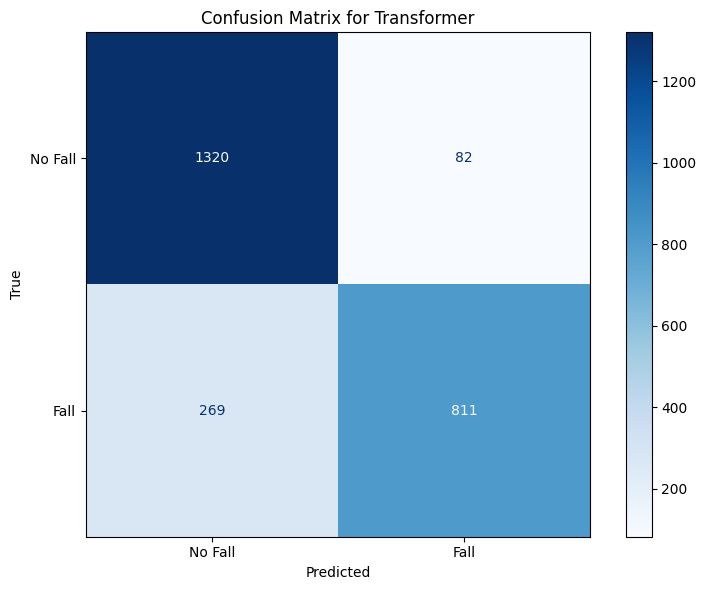

In [84]:
# Plot confusion matrix
confusion_matrix_plot(y_test, y_pred, "Confusion Matrix for Transformer")

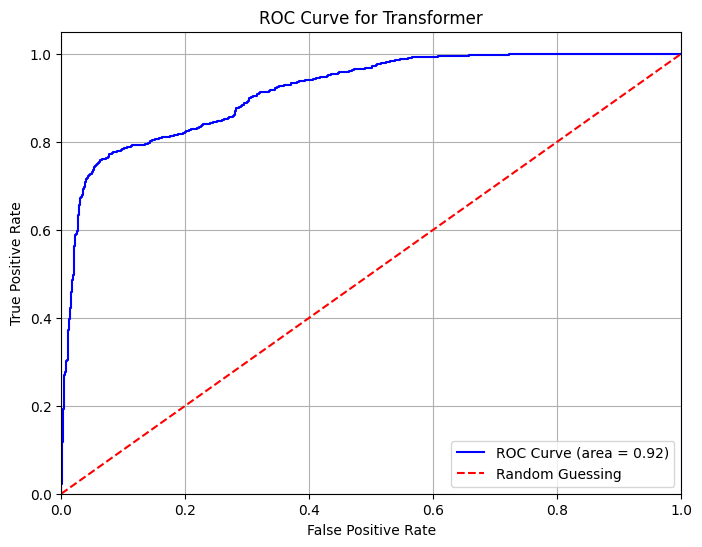

In [85]:
# Plot ROC curve
roc_curve_plot(y_test, y_pred_prob, "ROC Curve for Transformer")

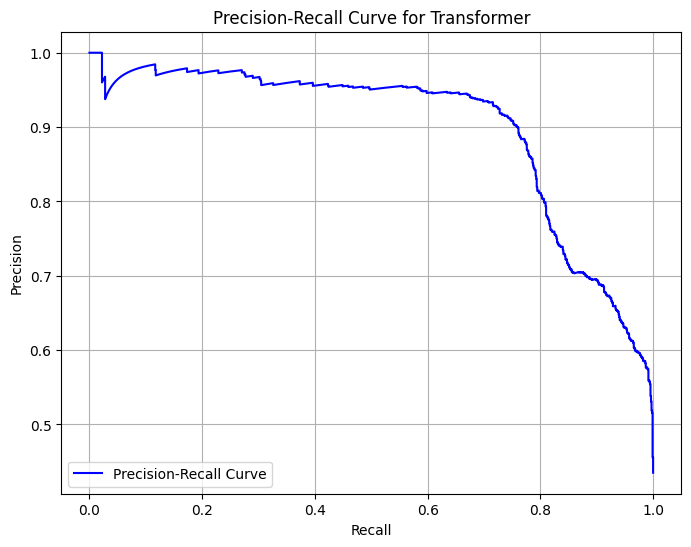

In [86]:
# Plot Recall-Precision curve
precision_recall_plot(y_test, y_pred_prob, "Precision-Recall Curve for Transformer")

In [87]:
# Save the model
transformer_model.save('transformer_model.keras')